In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import datetime
import json
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Paths

In [3]:
# AES
aes_dir = '../aes/output'
aes_log_file = aes_dir + '/aes.-1.ac.log'
aes_dot_log_file = aes_dir + '/aes.dot.log'
aes_vcd_log_file = aes_dir + '/aes.vcd.log'
aes_fanin_json = aes_dir + '/aes.fanin.json'
aes_reg2reg_json = aes_dir + '/aes.reg2reg.json'

# UART
uart_dir = '../uart/output'
uart_log_file = uart_dir + '/uart.-1.ac.log'
uart_dot_log_file = uart_dir + '/uart.dot.log'
uart_vcd_log_file = uart_dir + '/uart.vcd.log'
uart_fanin_json = uart_dir + '/uart.fanin.json'
uart_reg2reg_json = uart_dir + '/uart.reg2reg.json'

# OR1200
or1200_dir = '../or1200/output'
or1200_log_file = or1200_dir + '/or1200.-1.ac.log'
or1200_dot_log_file = or1200_dir + '/or1200.dot.log'
or1200_vcd_log_file = or1200_dir + '/or1200.vcd.log'
or1200_fanin_json = or1200_dir + '/or1200.fanin.json'
or1200_reg2reg_json = or1200_dir + '/or1200.reg2reg.json'

# PICORV32
picorv32_dir = '../picorv32/output'
picorv32_log_file = picorv32_dir + '/testbench.-1.ac.log'
picorv32_dot_log_file = picorv32_dir + '/testbench.dot.log'
picorv32_vcd_log_file = picorv32_dir + '/testbench.vcd.log'
picorv32_fanin_json = picorv32_dir + '/testbench.fanin.json'
picorv32_reg2reg_json = picorv32_dir + '/testbench.reg2reg.json'

# CORTEX-M0
cortex_m0_dir = '../arm_cortex_m0/output.bk'
cortex_m0_log_file = cortex_m0_dir + '/cortexm0ds_logic.-1.ac.log'
# cortex_m0_dot_log_file = cortex_m0_dir + '/cortexm0ds_logic.dot.log'
# cortex_m0_vcd_log_file = cortex_m0_dir + '/cortexm0ds_logic.vcd.log'
cortex_m0_fanin_json = cortex_m0_dir + '/cortexm0ds_logic.fanin.json'
cortex_m0_reg2reg_json = cortex_m0_dir + '/cortexm0ds_logic.reg2reg.json'

# Load Overall Fan-in/Reg2Reg Data

In [4]:
DESIGN_STR = 'Design'
TYPE_STR = 'Type'
FANIN_STR = 'Fan-in'
REG2REG_STR = 'Reg2Reg Distance'

fanin_data_dict = {
    DESIGN_STR: [],
    TYPE_STR: [],
    FANIN_STR: []
}

reg2reg_data_dict = {
    DESIGN_STR: [],
    TYPE_STR: [],
    REG2REG_STR: []
}

def load_stats(design, log_file):
    avg_fanin = -1
    max_fanin = -1
    avg_reg2reg_path = -1
    max_reg2reg_path = -1
    
    with open(log_file, "r") as f:
        for line in f:
            if "Average Fan-in" in line:
                avg_fanin = float(line.split('=')[-1].lstrip().rstrip())
            if "Max Fan-in" in line:
                max_fanin = int(line.split('=')[-1].lstrip().rstrip())
            if "Average Reg2Reg" in line:
                avg_reg2reg_path = float(line.split('=')[-1].lstrip().rstrip())
            if "Max Reg2Reg" in line:
                max_reg2reg_path = int(line.split('=')[-1].lstrip().rstrip())
    f.close()
    
    fanin_data_dict[DESIGN_STR].append(design)
    fanin_data_dict[DESIGN_STR].append(design)
    fanin_data_dict[TYPE_STR].append('Avg')
    fanin_data_dict[TYPE_STR].append('Max')
    fanin_data_dict[FANIN_STR].append(avg_fanin)
    fanin_data_dict[FANIN_STR].append(max_fanin)
    reg2reg_data_dict[DESIGN_STR].append(design)
    reg2reg_data_dict[DESIGN_STR].append(design)
    reg2reg_data_dict[TYPE_STR].append('Avg')
    reg2reg_data_dict[TYPE_STR].append('Max')
    reg2reg_data_dict[REG2REG_STR].append(avg_reg2reg_path)
    reg2reg_data_dict[REG2REG_STR].append(max_reg2reg_path)

load_stats('AES', aes_log_file)
load_stats('UART', uart_log_file)
load_stats('OR1200', or1200_log_file)
load_stats('RISC-V', picorv32_log_file)
load_stats('ARM CORTEX-M0', cortex_m0_log_file)

fanin_df = pd.DataFrame(fanin_data_dict)
reg2reg_df = pd.DataFrame(reg2reg_data_dict)
reg2reg_df

,Design,Type,Reg2Reg Distance
0,AES,Avg,1.734123
1,AES,Max,5.000000
2,UART,Avg,1.394872
3,UART,Max,6.000000
4,OR1200,Avg,1.647149
5,OR1200,Max,7.000000
6,RISC-V,Avg,1.553047
7,RISC-V,Max,6.000000
8,ARM CORTEX-M0,Avg,9.861144
9,ARM CORTEX-M0,Max,41.000000


# Load Local Fan-in/Reg2Reg Data

In [5]:
local_fanin_dict = {
    FANIN_STR: [],
    DESIGN_STR: []
}

local_reg2reg_dict = {
    REG2REG_STR: [],
    DESIGN_STR: []
}

# AES
with open(aes_fanin_json, "r") as jf:
    aes_fanin_dict = json.load(jf)
    local_fanin_dict[FANIN_STR].extend(aes_fanin_dict['Fan-in'])
    local_fanin_dict[DESIGN_STR].extend(['AES'] * len(aes_fanin_dict['Fan-in']))
jf.close()
with open(aes_reg2reg_json, "r") as jf:
    aes_reg2reg_dict = json.load(jf)
    local_reg2reg_dict[REG2REG_STR].extend(aes_reg2reg_dict['Reg2Reg Path Length'])
    local_reg2reg_dict[DESIGN_STR].extend(['AES'] * len(aes_reg2reg_dict['Reg2Reg Path Length']))
jf.close()

# UART
with open(uart_fanin_json, "r") as jf:
    uart_fanin_dict = json.load(jf)
    local_fanin_dict[FANIN_STR].extend(uart_fanin_dict['Fan-in'])
    local_fanin_dict[DESIGN_STR].extend(['UART'] * len(uart_fanin_dict['Fan-in']))
jf.close()
with open(uart_reg2reg_json, "r") as jf:
    uart_reg2reg_dict = json.load(jf)
    local_reg2reg_dict[REG2REG_STR].extend(uart_reg2reg_dict['Reg2Reg Path Length'])
    local_reg2reg_dict[DESIGN_STR].extend(['UART'] * len(uart_reg2reg_dict['Reg2Reg Path Length']))
jf.close()

# OR1200
with open(or1200_fanin_json, "r") as jf:
    or1200_fanin_dict = json.load(jf)
    local_fanin_dict[FANIN_STR].extend(or1200_fanin_dict['Fan-in'])
    local_fanin_dict[DESIGN_STR].extend(['OR1200'] * len(or1200_fanin_dict['Fan-in']))
jf.close()
with open(or1200_reg2reg_json, "r") as jf:
    or1200_reg2reg_dict = json.load(jf)
    local_reg2reg_dict[REG2REG_STR].extend(or1200_reg2reg_dict['Reg2Reg Path Length'])
    local_reg2reg_dict[DESIGN_STR].extend(['OR1200'] * len(or1200_reg2reg_dict['Reg2Reg Path Length']))
jf.close()

# RISC-V
with open(picorv32_fanin_json, "r") as jf:
    picorv32_fanin_dict = json.load(jf)
    local_fanin_dict[FANIN_STR].extend(picorv32_fanin_dict['Fan-in'])
    local_fanin_dict[DESIGN_STR].extend(['RISC-V'] * len(picorv32_fanin_dict['Fan-in']))
jf.close()
with open(picorv32_reg2reg_json, "r") as jf:
    picorv32_reg2reg_dict = json.load(jf)
    local_reg2reg_dict[REG2REG_STR].extend(picorv32_reg2reg_dict['Reg2Reg Path Length'])
    local_reg2reg_dict[DESIGN_STR].extend(['RISC-V'] * len(picorv32_reg2reg_dict['Reg2Reg Path Length']))
jf.close()

# ARM CORTEX M0
with open(cortex_m0_fanin_json, "r") as jf:
    cortex_m0_fanin_dict = json.load(jf)
    local_fanin_dict[FANIN_STR].extend(cortex_m0_fanin_dict['Fan-in'])
    local_fanin_dict[DESIGN_STR].extend(['ARM CORTEX-M0'] * len(cortex_m0_fanin_dict['Fan-in']))
jf.close()
with open(cortex_m0_reg2reg_json, "r") as jf:
    cortex_m0_reg2reg_dict = json.load(jf)
    local_reg2reg_dict[REG2REG_STR].extend(cortex_m0_reg2reg_dict['Reg2Reg Path Length'])
    local_reg2reg_dict[DESIGN_STR].extend(['ARM CORTEX-M0'] * len(cortex_m0_reg2reg_dict['Reg2Reg Path Length']))
jf.close()

local_fanin_df = pd.DataFrame(local_fanin_dict)
local_reg2reg_df = pd.DataFrame(local_reg2reg_dict)

# Remove Outliers
local_fanin_df[FANIN_STR] = np.where(local_fanin_df[FANIN_STR] > 50, 50, local_fanin_df[FANIN_STR])

# Load Run-time Data

In [8]:
SIM_RUNTIME_STR = 'Simulation Runtime (s)'
SSCCLASS_RUNTIME_STR = 'SSC Classification (s)'
SSCENUM_RUNTIME_STR = 'SSC Enumeration (s)'
DFGGEN_RUNTIME_STR = 'DFG Generation (s)'
TOTAL_RUNTIME_STR = 'Bomberman Runtime (s)'
SIZE_STR = 'Num. Regs'

runtime_data_dict = {
    DESIGN_STR: [],
    DFGGEN_RUNTIME_STR: [],
    SIM_RUNTIME_STR: [],
    SSCENUM_RUNTIME_STR: [],
    SSCCLASS_RUNTIME_STR: [],
    TOTAL_RUNTIME_STR: [],
    SIZE_STR: []
}

def convert_time_str_2_seconds(t_str):
    (seconds, frac_seconds) = t_str.split('.')
    x = time.strptime(seconds.split('.')[0], '%H:%M:%S')
    x = datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
    x += (float(frac_seconds) / 100.0)
    return x

def load_runtimes(design, log_file, dot_log_file, vcd_log_file):
    runtime_data_dict[DESIGN_STR].append(design)
    
    # IVL Stats
    with open(vcd_log_file, "r") as f:
        for line in f:
            if "real" in line:
                (seconds, frac_seconds) = line.split()[-1].rstrip().split('.')
                frac_seconds = float(frac_seconds.rstrip('s')) / 1000.0
                t = time.strptime(seconds, '%Mm%S')
                t = datetime.timedelta(hours=t.tm_hour,minutes=t.tm_min,seconds=t.tm_sec).total_seconds()
                sim_runtime = t + frac_seconds
                runtime_data_dict[SIM_RUNTIME_STR].append(sim_runtime)
    f.close()
    
    # DFG Stats
    with open(dot_log_file, "r") as f:
        for line in f:
            if "real" in line:
                (seconds, frac_seconds) = line.split()[-1].rstrip().split('.')
                frac_seconds = float(frac_seconds.rstrip('s')) / 1000.0
                t = time.strptime(seconds, '%Mm%S')
                t = datetime.timedelta(hours=t.tm_hour,minutes=t.tm_min,seconds=t.tm_sec).total_seconds()
                dfg_runtime = t + frac_seconds
                runtime_data_dict[DFGGEN_RUNTIME_STR].append(dfg_runtime)
    f.close()
    
    # Python Script Stats
    with open(log_file, "r") as f:
        for line in f:
            if "Num. Total FFs/Inputs:" in line:
                num_regs = int(line.split()[-1].rstrip())
                runtime_data_dict[SIZE_STR].append(num_regs)
            if "Identifying Coalesced Counter Candidates..." in line:
                for _ in range(5):
                    line = f.readline()
                ct_enum = convert_time_str_2_seconds(line.split()[-1].rstrip())
                for _ in range(7):
                    line = f.readline()
                dt_enum = convert_time_str_2_seconds(line.split()[-1].rstrip())
                total_enum = ct_enum + dt_enum
                runtime_data_dict[SSCENUM_RUNTIME_STR].append(total_enum)
            if "Finding malicious coalesced signals..." in line:
                while "Execution Time:" not in line:
                    line = f.readline()
                ct_class = convert_time_str_2_seconds(line.split()[-1].rstrip())
                while "Execution Time:" not in line:
                    line = f.readline()
                dt_class = convert_time_str_2_seconds(line.split()[-1].rstrip())
                total_class = ct_class + dt_class
                runtime_data_dict[SSCCLASS_RUNTIME_STR].append(total_class)
#             if "Analysis complete." in line:
#                 line = f.readline()
#                 line = f.readline()
#                 t = convert_time_str_2_seconds(line.split()[-1].rstrip())
#                 break
    f.close()

    total_bm_runtime = dfg_runtime + total_enum + total_class
    runtime_data_dict[TOTAL_RUNTIME_STR].append(total_bm_runtime)
    
    dfg_runtime_percentage = (float(dfg_runtime) / float(total_bm_runtime)) * 100.0
    total_enum_percentage = (float(total_enum) / float(total_bm_runtime)) * 100.0
    total_class_percentage = (float(total_class) / float(total_bm_runtime)) * 100.0
    percentages = [dfg_runtime_percentage, total_enum_percentage, total_class_percentage]
    
    return percentages

aes_runtime_percentages = load_runtimes('AES', aes_log_file, aes_dot_log_file, aes_vcd_log_file)
uart_runtime_percentages = load_runtimes('UART', uart_log_file, uart_dot_log_file, uart_vcd_log_file)
or1200_runtime_percentages = load_runtimes('OR1200', or1200_log_file, or1200_dot_log_file, or1200_vcd_log_file)
picorv32_runtime_percentages = load_runtimes('RISC-V', picorv32_log_file, picorv32_dot_log_file, picorv32_vcd_log_file)
runtime_df = pd.DataFrame(runtime_data_dict)

print(runtime_df)

   Design  DFG Generation (s)  Simulation Runtime (s)  SSC Enumeration (s)  \
0     AES               5.017                   3.658                 0.24   
1    UART               0.412                   3.972                 0.60   
2  OR1200              14.290                  27.602                 7.00   
3  RISC-V               0.360                   5.572                 9.28   

   SSC Classification (s)  Bomberman Runtime (s)  Num. Regs  
0                    0.20                  5.457       2440  
1                    3.90                  4.912        340  
2                    1.28                 22.570        814  
3                    1.20                 10.840        317  


# Plot Settings

In [9]:
# Set Color Scheme
sns.set()

# Plot Runtime Breakdown

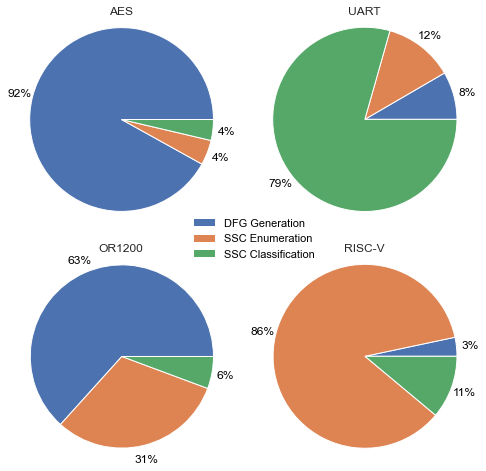

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor'] = '#000000'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size'] = 12
color_palette_list = sns.color_palette()
# color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', '#C1F0F6', '#0099CC']
labels = ['DFG Generation', 'SSC Enumeration', 'SSC Classification']
explode = (0, 0, 0)
PERCENTAGE_DIST = 1.15

# AES
ax1.pie(aes_runtime_percentages, explode=explode,
       colors=color_palette_list[0:3], autopct='%1.0f%%', 
       shadow=False, startangle=0, pctdistance=PERCENTAGE_DIST)
ax1.axis('equal')
ax1.set_title("AES")

# UART
ax2.pie(uart_runtime_percentages, explode=explode,
       colors=color_palette_list[0:3], autopct='%1.0f%%', 
       shadow=False, startangle=0, pctdistance=PERCENTAGE_DIST)
ax2.axis('equal')
ax2.set_title("UART")

# OR1200
ax3.pie(or1200_runtime_percentages, explode=explode,
       colors=color_palette_list[0:3], autopct='%1.0f%%', 
       shadow=False, startangle=0, pctdistance=PERCENTAGE_DIST)
ax3.axis('equal')
ax3.set_title("OR1200")

# RISC-V
ax4.pie(picorv32_runtime_percentages, explode=explode,
       colors=color_palette_list[0:3], autopct='%1.0f%%', 
       shadow=False, startangle=0, pctdistance=PERCENTAGE_DIST)
ax4.axis('equal')
ax4.set_title("RISC-V")
ax4.legend(frameon=False, labels=labels, bbox_to_anchor=(0.3,1.25))
plt.savefig('bomberman_runtime_breakdown.pdf', format='pdf')

# Plot Fan-in & Reg2Reg Path

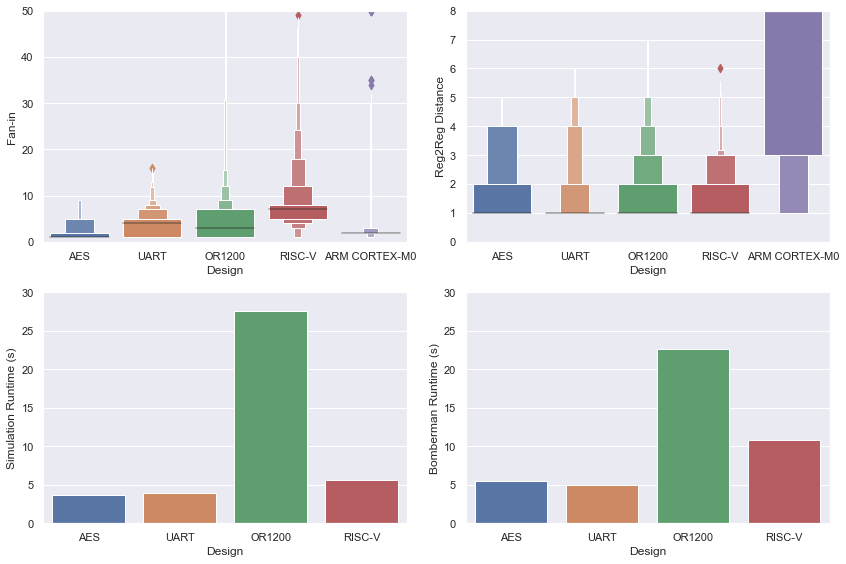

In [11]:
sns.set()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
sns.boxenplot(x=DESIGN_STR, y=FANIN_STR, data=local_fanin_df, linewidth=2.5, ax=ax1)
ax1.set_ylim([0,50])
sns.boxenplot(x=DESIGN_STR, y=REG2REG_STR, data=local_reg2reg_df, linewidth=2.5, ax=ax2)
ax2.set_ylim([0,8])
sns.barplot(x=DESIGN_STR, y=SIM_RUNTIME_STR, data=runtime_df, ax=ax3)
ax3.set_ylim([0,30])
sns.barplot(x=DESIGN_STR, y=TOTAL_RUNTIME_STR, data=runtime_df, ax=ax4)
ax4.set_ylim([0,30])
plt.tight_layout()
plt.savefig('bomberman_complexity_analysis.pdf', format='pdf')

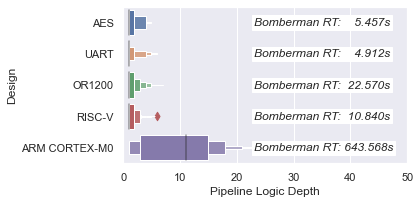

In [44]:
sns.set()
fig, ax_r2r = plt.subplots(1, 1, figsize=(6, 3))
# sns.boxenplot(x=DESIGN_STR, y=REG2REG_STR, data=local_reg2reg_df, linewidth=2.5, ax=ax_r2r)
# sns.swarmplot(x=DESIGN_STR, y=REG2REG_STR, data=local_reg2reg_df, ax=ax_r2r)
sns.boxenplot(x=REG2REG_STR, y=DESIGN_STR, data=local_reg2reg_df, linewidth=2.5, ax=ax_r2r)
# sns.swarmplot(x=REG2REG_STR, y=DESIGN_STR, data=local_reg2reg_df, ax=ax_r2r)
ax_r2r.set_xlim([0,50])
ax_r2r.set_xlabel('Pipeline Logic Depth')
ax_r2r.set_ylabel('Design')
plt.tight_layout()
ax_r2r.text(23, 0.1, 'Bomberman RT:    5.457s', style='italic', bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 2})
ax_r2r.text(23, 1.1, 'Bomberman RT:    4.912s', style='italic', bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 2})
ax_r2r.text(23, 2.1, 'Bomberman RT:  22.570s', style='italic', bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 2})
ax_r2r.text(23, 3.1, 'Bomberman RT:  10.840s', style='italic', bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 2})
ax_r2r.text(23, 4.1, 'Bomberman RT: 643.568s', style='italic', bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 2})
plt.savefig('bomberman_reg2reg_analysis_warm_rts.pdf', format='pdf')

   Bomberman Runtime (s)  DFG Generation (s)  Design  Num. Regs  \
0                  5.457               5.017     AES       2440   
1                  4.912               0.412    UART        340   
2                 22.570              14.290  OR1200        814   
3                 10.840               0.360  RISC-V        317   

   SSC Classification (s)  SSC Enumeration (s)  Simulation Runtime (s)  
0                    0.20                 0.24                   3.658  
1                    3.90                 0.60                   3.972  
2                    1.28                 7.00                  27.602  
3                    1.20                 9.28                   5.572  


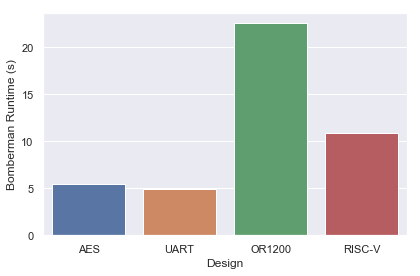

In [11]:
sns.set()
fig, ax_runtime = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(x=DESIGN_STR, y=TOTAL_RUNTIME_STR, data=runtime_df, ax=ax_runtime)
ax_r2r.set_ylim([0,30])
# ax_r2r.set_ylabel('Pipeline Logic Depth\n(# stages)')
# ax_r2r.set_xlabel('Design\n(Max. Clock Frequency)')
plt.tight_layout()
plt.savefig('bomberman_runtimes.pdf', format='pdf')
print runtime_df